In [45]:
import pandas as pd
import numpy as np
from datetime import datetime

### Load data
You can download these files from /Laptev_Sea/global_database/data

In [219]:
data1 = pd.read_csv('usgs_data.txt')
data2 = pd.read_csv('isc_data.txt')
data3 = pd.read_csv('db_earthquakes_of_Russia.txt')

In [286]:
# Make a column for a source
data1['source'] = 'USGS'
data2['source'] = 'ISC'
data3['source'] = 'db_earthquakes_of_Russia'

### Unify all events, make a column for datetime format

In [221]:
all_data = pd.concat([data1, data2, data3], ignore_index=True, sort=False)

In [222]:
# Function to make datetime column

def to_datetime(num_of_row):
    year = int(all_data['date'][num_of_row].split('-')[0])
    month = int(all_data['date'][num_of_row].split('-')[1])
    day = int(all_data['date'][num_of_row].split('-')[2])
    hour = int(all_data['time'][num_of_row].split(':')[0])
    minute = int(all_data['time'][num_of_row].split(':')[1])
    second = int(all_data['time'][num_of_row].split(':')[2])
    return datetime(year, month, day, hour, minute, second)

In [223]:
all_data['datetime'] = [to_datetime(n) for n in range(len(all_data))]

In [224]:
all_data.head(2)

,date,time,latitude,longitude,depth,magnitude,magtype,source,datetime
0,2019-08-04,13:22:56,71.4671,138.4826,10.0,4.3,mb,USGS,2019-08-04 13:22:56
1,2019-05-21,03:45:11,75.4930,110.1978,10.0,4.8,mb,USGS,2019-05-21 03:45:11


### Sort data

In [225]:
sorted_data = all_data.sort_values(by=['datetime'], inplace=False, ascending=True)

In [226]:
sorted_data.index = range(len(all_data))

In [227]:
sorted_data.head(2)

,date,time,latitude,longitude,depth,magnitude,magtype,source,datetime
0,1909-04-10,18:46:54,77.5,128.0,35.0,6.75,MS,ISC,1909-04-10 18:46:54
1,1912-04-13,02:39:42,80.0,100.0,35.0,5.60,MS,ISC,1912-04-13 02:39:42


### Find duplicates

In [228]:
# Function to find difference in seconds between 2 rows
def sec_diff(row2, row1):
    return (sorted_data['datetime'][row2] - sorted_data['datetime'][row1]).total_seconds()

In [229]:
# Сompare the time difference in seconds between 2 adjacent lines. 
# If the difference is less than n_sec then we consider the first event to be a duplicate.
# Based on this definition, the last event is never a duplicate.
def find_duplicates(n_sec):
    duplicates_list = []
    for row1 in range(len(sorted_data) - 1):
        if sec_diff(row1 + 1, row1) < n_sec:
            duplicates_list.append(True)
        else:
            duplicates_list.append(False)
    duplicates_list.append(False)
    return duplicates_list

### Statistics of duplicates

In [230]:
n_sec = [60 * i for i in range(11)]
num_of_duplicates = []

In [231]:
for n in n_sec:
    sorted_data['is_duplicate'] = find_duplicates(n)
    num_of_duplicates.append(sorted_data['is_duplicate'].sum())

In [232]:
from matplotlib import pyplot as plt
%matplotlib inline

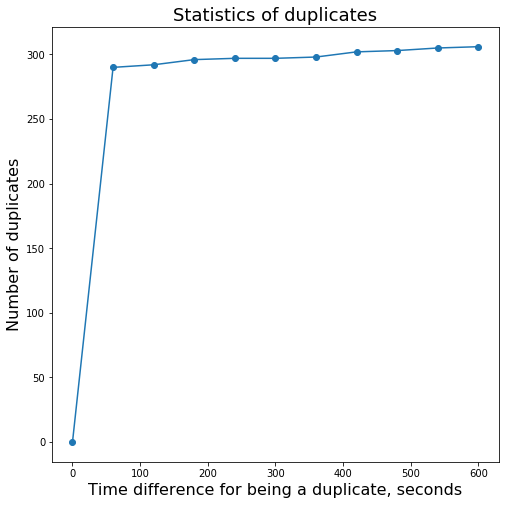

In [262]:
plt.figure(figsize=(8,8))
plt.scatter(n_sec, num_of_duplicates)
plt.plot(n_sec, num_of_duplicates)
plt.xlabel('Time difference for being a duplicate, seconds', fontsize=16)
plt.ylabel('Number of duplicates', fontsize=16)
plt.title('Statistics of duplicates', fontsize=18)
plt.show()

#### Let's take n_sec = 100 for being a duplicate

### Drop duplicates

In [234]:
sorted_data['is_duplicate'] = find_duplicates(100)

In [238]:
unified_data = sorted_data[sorted_data['is_duplicate'] == False]
unified_data.index = range(len(unified_data))

In [242]:
ISC_events = len(unified_data[unified_data['source'] == 'ISC'])
USGS_events = len(unified_data[unified_data['source'] == 'USGS'])
earthquakes_of_Russia_events = len(unified_data[unified_data['source'] == 'db_earthquakes_of_Russia'])

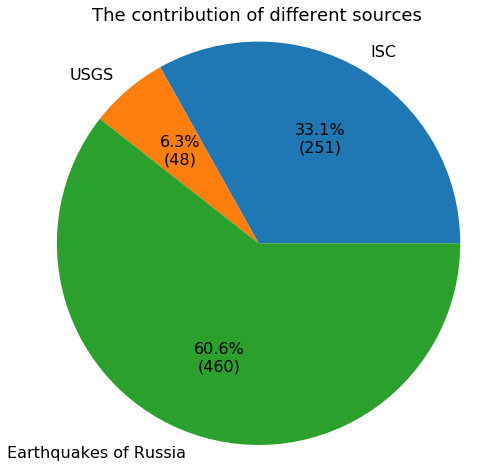

In [287]:
# Function to get percentage and number of events
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

vals = [ISC_events, USGS_events, earthquakes_of_Russia_events]
labels = ["ISC", "USGS", "Earthquakes of Russia"]
fig, ax = plt.subplots(figsize=(8, 8))

ax.pie(vals, labels=labels, autopct=lambda pct: func(pct, vals), textprops={'fontsize': 16})
ax.axis("equal")
ax.set_title('The contribution of different sources', fontsize=18)
plt.show()


### Save unified database

In [285]:
unified_data[['date', 'time', 'latitude', 'longitude', 'depth', 'magnitude', 'magtype', 'source']].to_csv('unified_db.txt', index=False)